In [1]:
# Importing necessary libraries
import numpy as np
import matplotlib.pyplot as plt

Fisher Information Matrix (FIM)

In [2]:
import numpy as np

# Parameters
sigma_noise = 1  # Noise variance (for simplicity, set as 1)
L = 25  # Number of observations
M = 2  # Number of receivers (can be 2 for simplicity in this example)

# Placeholder function for derivative of the observation wrt theta (simplified)
def h_theta_derivative(theta, l):
    # In reality, this would involve differentiating the signal model wrt theta
    # Here, we assume some simplified derivative function
    return np.array([np.cos(theta), np.sin(theta)])

# Fisher Information Matrix calculation (I(θ))
def fisher_information_matrix(theta):
    I_theta = np.zeros((2 * M, 2 * M))  # Fisher Information Matrix (2M x 2M)
    for l in range(L):
        for i in range(2 * M):
            for j in range(2 * M):
                h_i = h_theta_derivative(theta[i], l)
                h_j = h_theta_derivative(theta[j], l)
                I_theta[i, j] += 2 / sigma_noise * np.real(np.dot(h_i.T, h_j))
    return I_theta

# Example theta (angle parameters)
theta = np.random.rand(2 * M) * np.pi / 2

# Calculate the Fisher Information Matrix
I_theta = fisher_information_matrix(theta)

print("Fisher Information Matrix (I(θ)):")
print(I_theta)

Fisher Information Matrix (I(θ)):
[[50.         48.55855616 46.60027133 46.39442286]
 [48.55855616 50.         49.57687346 49.50108057]
 [46.60027133 49.57687346 50.         49.9968652 ]
 [46.39442286 49.50108057 49.9968652  50.        ]]


Transformation Matrix (T)

In [3]:
import numpy as np

# Parameters
M = 2  # Number of receivers

# Function to compute the transformation matrix T
def transformation_matrix(theta, p):
    T = np.zeros((2 * M, 2))  # Transformation matrix (2M x 2)

    # Compute partial derivatives wrt to receiver coordinates (x, y)
    for i in range(2 * M):
        for j in range(2):
            T[i, j] = np.cos(theta[i]) if j == 0 else np.sin(theta[i])
    return T

# Example receiver coordinates (p) and theta values
p = np.array([1.0, 2.0])  # Receiver coordinates (x, y)
theta = np.random.rand(2 * M) * np.pi / 2  # Theta values

# Calculate the transformation matrix
T = transformation_matrix(theta, p)

print("Transformation Matrix (T):")
print(T)


Transformation Matrix (T):
[[0.96959467 0.24471651]
 [0.00336627 0.99999433]
 [0.99082595 0.13514414]
 [0.26897888 0.96314608]]


CRLB Matrix

In [4]:
import numpy as np

# Fisher Information Matrix (from Notebook 1)
def fisher_information_matrix(theta, L=25, M=2, sigma_noise=1):
    I_theta = np.zeros((2 * M, 2 * M))
    for l in range(L):
        for i in range(2 * M):
            for j in range(2 * M):
                h_i = np.array([np.cos(theta[i]), np.sin(theta[i])])
                h_j = np.array([np.cos(theta[j]), np.sin(theta[j])])
                I_theta[i, j] += 2 / sigma_noise * np.real(np.dot(h_i.T, h_j))
    return I_theta

# Transformation Matrix (from Notebook 2)
def transformation_matrix(theta, M=2):
    T = np.zeros((2 * M, 2))
    for i in range(2 * M):
        for j in range(2):
            T[i, j] = np.cos(theta[i]) if j == 0 else np.sin(theta[i])
    return T

# Calculate the CRLB matrix
def crlb_matrix(theta, p, L=25, M=2, sigma_noise=1):
    I_theta = fisher_information_matrix(theta, L, M, sigma_noise)
    T = transformation_matrix(theta, M)
    I_p = np.dot(np.dot(T.T, I_theta), T)  # Fisher info matrix about receiver position
    crlb = np.linalg.inv(I_p)  # Cramér-Rao Lower Bound matrix
    return crlb

# Example values
theta = np.random.rand(2 * M) * np.pi / 2  # Random theta values
p = np.array([1.0, 2.0])  # Receiver coordinates

# Calculate the CRLB matrix
crlb = crlb_matrix(theta, p)

print("Cramér-Rao Lower Bound Matrix (CRLB):")
print(crlb)


Cramér-Rao Lower Bound Matrix (CRLB):
[[ 0.06229983 -0.08284781]
 [-0.08284781  0.11436627]]


Position Error Matrix (MSE)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
grid_size = 100  # Area size (100 x 100 meters)
grid_spacing = 0.4  # Grid spacing in meters
L = 25  # Number of observations
sigma_noise = 1  # Noise variance
monte_carlo_trials = 1000  # Number of Monte Carlo trials

# Function to calculate the distance and angle between receiver and RIS
def compute_distance_and_angle(rx_pos, ris_pos):
    distance = np.linalg.norm(np.array(ris_pos) - np.array(rx_pos))
    angle = np.arctan2(rx_pos[1] - ris_pos[1], rx_pos[0] - ris_pos[0])
    return distance, angle

# Log-likelihood function
def log_likelihood(rx_pos, ris_positions, phi_vals, L, sigma_noise):
    ll_value = 0
    for ris_pos in ris_positions:
        d, phi = compute_distance_and_angle(rx_pos, ris_pos)
        for phi_l in phi_vals:
            ll_value += np.exp(-((phi - phi_l)**2) / (2 * sigma_noise**2))
    return ll_value

# Monte Carlo simulation for MSE
def monte_carlo_mse(ris_positions, phi_vals, L, sigma_noise, trials, grid_spacing, grid_size):
    x_vals = np.arange(-grid_size / 2, grid_size / 2, grid_spacing)
    y_vals = np.arange(-grid_size / 2, grid_size / 2, grid_spacing)
    X, Y = np.meshgrid(x_vals, y_vals)
    mse_map = np.zeros_like(X)

    total_iterations = X.shape[0] * X.shape[1]
    completed_iterations = 0

    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            candidate_pos = (X[i, j], Y[i, j])
            error_sum = 0
            for _ in range(trials):
                noisy_receiver_pos = np.random.normal(0, sigma_noise, 2)  # Add noise
                ll_true = log_likelihood(noisy_receiver_pos, ris_positions, phi_vals, L, sigma_noise)
                ll_candidate = log_likelihood(candidate_pos, ris_positions, phi_vals, L, sigma_noise)
                error_sum += (ll_true - ll_candidate) ** 2
            mse_map[i, j] = error_sum / trials

            completed_iterations += 1
            if completed_iterations % 100 == 0: # Log every 100 iterations
                print(f"Completed {completed_iterations}/{total_iterations} grid points.")


    return mse_map

# Example RIS positions and phi values
ris_positions = [(-15, -15), (30, -15)]
phi_vals = np.linspace(0, np.pi / 2, L)

# Calculate MSE map
mse_map = monte_carlo_mse(ris_positions, phi_vals, L, sigma_noise, monte_carlo_trials, grid_spacing, grid_size)

# Plotting the MSE map
plt.contourf(X, Y, mse_map, cmap='coolwarm', levels=100)
plt.colorbar(label="MSE")
plt.title("Position Error (MSE) Map")
plt.xlabel("X Position (meters)")
plt.ylabel("Y Position (meters)")
plt.show()

Completed 100/62500 grid points.
Completed 200/62500 grid points.


<ipython-input-2-48b13bd64f89>:66: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  r_total[t] = h_sum + noise


True Receiver Position: [50 50]
Estimated Receiver Position: [81.63265306 10.20408163]


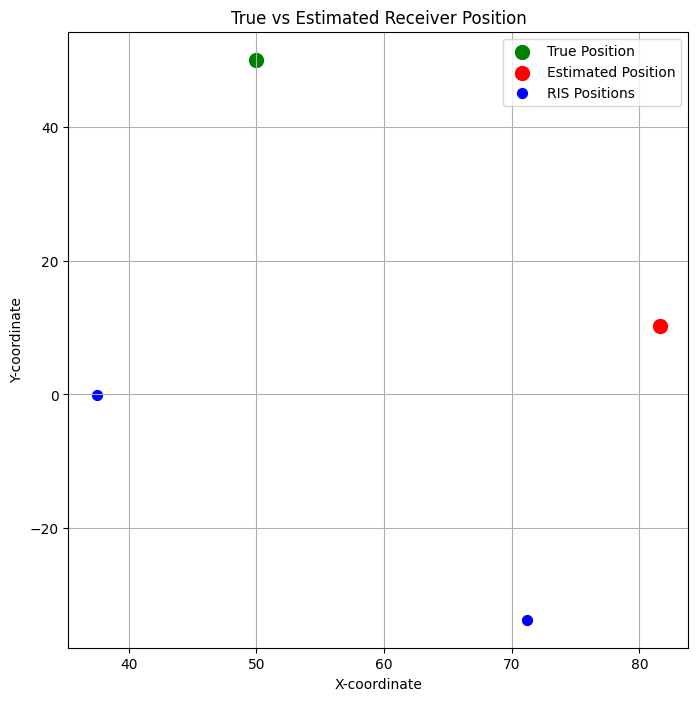

In [ ]:
# Constants and Parameters
M = 2  # Number of RISs
N = 10  # Number of elements per RIS
fc = 3e9  # Carrier frequency (3 GHz)
c = 3e8  # Speed of light (m/s)
lambda_c = c / fc  # Wavelength (m)
k = 2 * np.pi / lambda_c  # Wavenumber
sigma2 = 1e-3  # Noise variance (AWGN)
time_slots = 100  # Number of independent time slots

# Transmitter and RIS coordinates (assumed to be known)
tx_pos = np.array([0, 0])
ris_pos = np.random.uniform(low=-100, high=100, size=(M, 2))  # Random positions for RISs

# Receiver's true position (unknown)
rx_true_pos = np.array([50, 50])

# Function to calculate distance between two points
def calc_distance(p1, p2):
    return np.linalg.norm(p1 - p2)

# Function to compute path loss using Friis transmission model
def calc_path_loss(d, epsilon=1):
    return epsilon / (4 * np.pi * d**2)

# Function to compute phase shifts across RIS elements
def calc_phase_shift(d, k, N, angle_tx, angle_rx, time_slot):
    # Reconfiguring RIS phase shift for the given time slot
    phase_shifts = np.array([
        k * n * lambda_c * (np.sin(angle_tx) - np.sin(np.random.uniform(0, np.pi / 2))) for n in range(N)
    ])
    return np.exp(1j * phase_shifts)

# Channel model for a single RIS at the l-th time slot
def channel_model(tx_pos, rx_pos, ris_pos, N, k, time_slot):
    d_tx_ris = calc_distance(tx_pos, ris_pos)
    d_ris_rx = calc_distance(ris_pos, rx_pos)

    # Path loss
    beta_tx = calc_path_loss(d_tx_ris)
    beta_rx = calc_path_loss(d_ris_rx)

    # Angles for phase shifts
    angle_tx = np.arctan2(ris_pos[1] - tx_pos[1], ris_pos[0] - tx_pos[0])
    angle_rx = np.arctan2(rx_pos[1] - ris_pos[1], rx_pos[0] - ris_pos[0])

    # Compute phase shifts for both hops at time slot l
    h_tx = calc_phase_shift(d_tx_ris, k, N, angle_tx, angle_rx, time_slot)
    h_rx = calc_phase_shift(d_ris_rx, k, N, angle_tx, angle_rx, time_slot)

    # Composite channel model
    h = beta_tx * beta_rx * h_rx.T @ h_tx
    return h

# Function to compute the received signal for multiple time slots
def received_signal(tx_pos, rx_pos, ris_pos, N, M, k, time_slots, sigma2):
    r_total = np.zeros(time_slots, dtype=complex)

    for t in range(time_slots):
        h_sum = 0
        for m in range(M):
            h = channel_model(tx_pos, rx_pos, ris_pos[m], N, k, t)
            h_sum += h

        noise = np.random.normal(0, np.sqrt(sigma2), size=(1)) + 1j * np.random.normal(0, np.sqrt(sigma2), size=(1))
        r_total[t] = h_sum + noise

    return r_total

# Function to compute the log-likelihood
def log_likelihood(rx_pos, tx_pos, ris_pos, N, M, k, time_slots, r_observed, sigma2):
    r_predicted = received_signal(tx_pos, rx_pos, ris_pos, N, M, k, time_slots, sigma2)
    return -np.linalg.norm(r_observed - r_predicted)**2

# Exhaustive grid search for ML estimation
def grid_search(tx_pos, ris_pos, N, M, k, time_slots, r_observed, sigma2, grid_size, grid_range):
    x_vals = np.linspace(grid_range[0], grid_range[1], grid_size)
    y_vals = np.linspace(grid_range[0], grid_range[1], grid_size)

    max_likelihood = -np.inf
    best_pos = None

    for x in x_vals:
        for y in y_vals:
            rx_pos = np.array([x, y])
            likelihood = log_likelihood(rx_pos, tx_pos, ris_pos, N, M, k, time_slots, r_observed, sigma2)
            if likelihood > max_likelihood:
                max_likelihood = likelihood
                best_pos = rx_pos

    return best_pos

# Simulate the received signal for the true receiver position
r_observed = received_signal(tx_pos, rx_true_pos, ris_pos, N, M, k, time_slots, sigma2)

# Perform grid search to estimate receiver position
estimated_pos = grid_search(tx_pos, ris_pos, N, M, k, time_slots, r_observed, sigma2, grid_size=50, grid_range=[0, 100])

# Print the results
print(f"True Receiver Position: {rx_true_pos}")
print(f"Estimated Receiver Position: {estimated_pos}")

# Plot the results
plt.figure(figsize=(8, 8))
plt.scatter(rx_true_pos[0], rx_true_pos[1], c='green', label="True Position", s=100)
plt.scatter(estimated_pos[0], estimated_pos[1], c='red', label="Estimated Position", s=100)
plt.scatter(ris_pos[:, 0], ris_pos[:, 1], c='blue', label="RIS Positions", s=50)
plt.legend()
plt.xlabel('X-coordinate')
plt.ylabel('Y-coordinate')
plt.title('True vs Estimated Receiver Position')
plt.grid(True)
plt.show()


In [ ]:
import numpy as np

# Constants and parameters
M = 5  # Number of RISs
L = 100  # Number of time slots
sigma2 = 1e-3  # Noise variance (AWGN)

# Placeholder for partial derivatives of hl with respect to theta
def partial_derivatives_hl(rx_pos, tx_pos, ris_pos, N, M, k, time_slot):
    # Placeholder logic to compute partial derivatives of hl with respect to each theta_i
    # This function needs to be implemented according to the specific model of hl in your system
    # For simplicity, we assume it returns a random matrix for demonstration
    return np.random.randn(2 * M, 1)

# Fisher information matrix computation
def fisher_information(rx_pos, tx_pos, ris_pos, N, M, k, time_slots, sigma2):
    I_theta = np.zeros((2 * M, 2 * M))

    for l in range(time_slots):
        # Compute the partial derivatives of hl with respect to each theta_i
        partials = partial_derivatives_hl(rx_pos, tx_pos, ris_pos, N, M, k, l)

        # Compute the Fisher information matrix using equation (17)
        I_theta += (2 / sigma2) * np.real(np.dot(partials, partials.T))

    return I_theta

# Transformation matrix T for converting from polar to Cartesian coordinates
def transformation_matrix(rx_pos, ris_pos, M):
    T = np.zeros((2 * M, 2))

    for m in range(M):
        d_rx_m = np.linalg.norm(ris_pos[m] - rx_pos)
        phi_rx_m = np.arctan2(ris_pos[m, 1] - rx_pos[1], ris_pos[m, 0] - rx_pos[0])

        # Compute the partial derivatives of theta with respect to Cartesian coordinates
        T[2 * m, 0] = (rx_pos[0] - ris_pos[m, 0]) / d_rx_m  # ∂d_rx,m / ∂x
        T[2 * m, 1] = (rx_pos[1] - ris_pos[m, 1]) / d_rx_m  # ∂d_rx,m / ∂y
        T[2 * m + 1, 0] = -(rx_pos[1] - ris_pos[m, 1]) / d_rx_m**2  # ∂phi_rx,m / ∂x
        T[2 * m + 1, 1] = (rx_pos[0] - ris_pos[m, 0]) / d_rx_m**2   # ∂phi_rx,m / ∂y

    return T

# Function to compute the Cramér-Rao Lower Bound (CRLB)
def cramer_rao_lower_bound(rx_pos, tx_pos, ris_pos, N, M, k, time_slots, sigma2):
    # Step 1: Compute the Fisher information matrix I(theta)
    I_theta = fisher_information(rx_pos, tx_pos, ris_pos, N, M, k, time_slots, sigma2)

    # Step 2: Compute the transformation matrix T
    T = transformation_matrix(rx_pos, ris_pos, M)

    # Step 3: Compute the Fisher information matrix in Cartesian coordinates I(p)
    I_p = np.dot(np.dot(T.T, I_theta), T)

    # Step 4: Compute the Cramér-Rao Lower Bound (CRLB)
    crlb = np.trace(np.linalg.inv(I_p))

    return crlb

# Simulate the CRLB for a given receiver position
rx_pos = np.array([50, 50])
tx_pos = np.array([0, 0])
ris_pos = np.random.uniform(low=-100, high=100, size=(M, 2))  # Random positions for RISs
N = 10  # Number of RIS elements
k = 2 * np.pi / (3e8 / 3e9)  # Wavenumber for 3 GHz

# Compute the CRLB
crlb = cramer_rao_lower_bound(rx_pos, tx_pos, ris_pos, N, M, k, L, sigma2)

print(f"Cramér-Rao Lower Bound (CRLB): {crlb:.4f}")


Cramér-Rao Lower Bound (CRLB): 0.0000


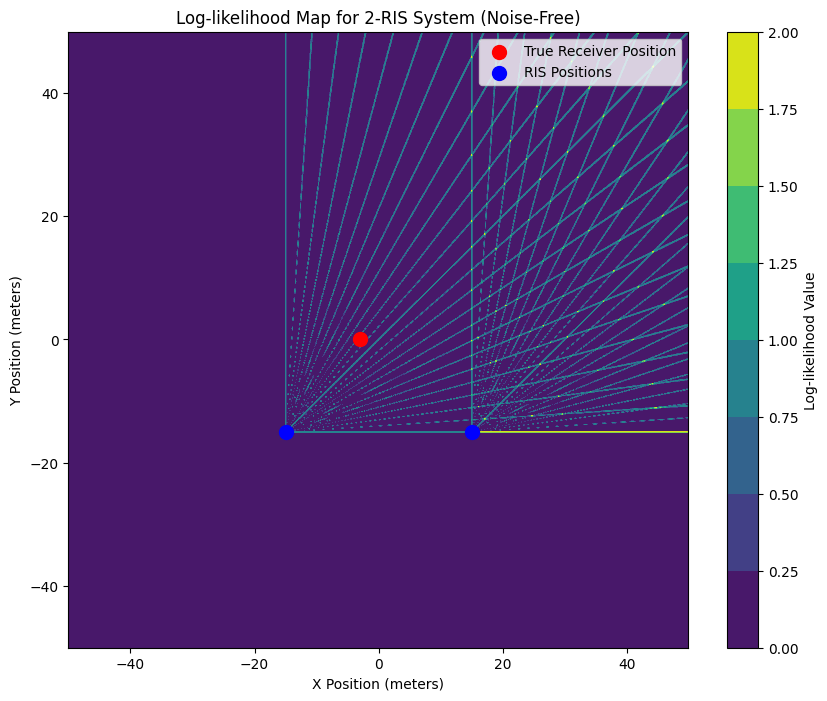

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Simulation Parameters
grid_size = 100  # Size of the area (100m x 100m)
grid_spacing = 0.1  # Spacing between grid points
ris_positions = [(-15, -15), (15, -15)]  # Central positions of the RISs
receiver_position = (-3, 0)  # True position of the receiver in 2-RIS setup
L = 25  # Number of different beamforming directions
phi_range = np.linspace(0, np.pi/2, L)  # Values of phi in [0, pi/2]
sigma_noise = 0  # Noise variance for noise-free environment

# Helper function to calculate distances and angles
def compute_distance_and_angle(rx_pos, ris_pos):
    d = np.linalg.norm(np.array(ris_pos) - np.array(rx_pos))  # Distance between RIS and receiver
    angle = np.arctan2(rx_pos[1] - ris_pos[1], rx_pos[0] - ris_pos[0])  # Angle between RIS and receiver
    return d, angle

# Log-likelihood function for a candidate position
def log_likelihood(rx_pos, ris_positions, phi_vals, L, sigma_noise):
    log_likelihood_val = 0

    # For each RIS, compute the likelihood based on the beamforming directions
    for ris_pos in ris_positions:
        d, phi = compute_distance_and_angle(rx_pos, ris_pos)
        for phi_l in phi_vals:
            # Log-likelihood (simplified, ignoring exact model specifics for clarity)
            log_likelihood_val += np.exp(-((phi - phi_l)**2) / (2 * sigma_noise**2 + 1e-6))

    return log_likelihood_val

# Create the grid of candidate positions
x_vals = np.arange(-grid_size/2, grid_size/2, grid_spacing)
y_vals = np.arange(-grid_size/2, grid_size/2, grid_spacing)
X, Y = np.meshgrid(x_vals, y_vals)

# Simulate the log-likelihood map for the 2-RIS system
log_likelihood_map = np.zeros_like(X)

for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        candidate_pos = (X[i, j], Y[i, j])
        log_likelihood_map[i, j] = log_likelihood(candidate_pos, ris_positions, phi_range, L, sigma_noise)

# Plotting the log-likelihood map
plt.figure(figsize=(10, 8))
plt.contourf(X, Y, log_likelihood_map, cmap='viridis')
plt.colorbar(label="Log-likelihood Value")
plt.scatter(*receiver_position, color='red', label="True Receiver Position", s=100)
plt.scatter(*np.array(ris_positions).T, color='blue', label="RIS Positions", s=100)
plt.legend()
plt.title("Log-likelihood Map for 2-RIS System (Noise-Free)")
plt.xlabel("X Position (meters)")
plt.ylabel("Y Position (meters)")
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
grid_size = 100  # Size of the area (100m x 100m)
grid_spacing = 0.4  # Grid spacing of 0.4 meters
noise_power_dBW = -105  # Noise power in dBW
noise_power = 10 ** (noise_power_dBW / 10)  # Convert dBW to linear scale
L = 25  # Number of different beamforming directions
phi_range = np.linspace(0, np.pi / 2, L)  # Values of phi in [0, pi/2]
monte_carlo_trials = 1000  # Number of Monte Carlo simulations

# RIS positions for different scenarios
ris_positions_1 = [(-15, -15)]  # One RIS
ris_positions_2_seq = [(-15, -15), (30, -15)]  # Two RISs - sequential protocol
ris_positions_2_stoch = [(-15, -15), (15, -15)]  # Two RISs - stochastic protocol

# True receiver position for simulation
true_receiver_position = (0.02, 15.02)

# Helper function to cal culate distances and angles
def compute_distance_and_angle(rx_pos, ris_pos):
    d = np.linalg.norm(np.array(ris_pos) - np.array(rx_pos))  # Distance between RIS and receiver
    angle = np.arctan2(rx_pos[1] - ris_pos[1], rx_pos[0] - ris_pos[0])  # Angle between RIS and receiver
    return d, angle

# Log-likelihood function for a candidate position
def log_likelihood(rx_pos, ris_positions, phi_vals, L, sigma_noise):
    log_likelihood_val = 0

    # For each RIS, compute the likelihood based on the beamforming directions
    for ris_pos in ris_positions:
        d, phi = compute_distance_and_angle(rx_pos, ris_pos)
        for phi_l in phi_vals:
            # Log-likelihood (simplified, ignoring exact model specifics for clarity)
            log_likelihood_val += np.exp(-((phi - phi_l)**2) / (2 * sigma_noise**2 + 1e-6))

    return log_likelihood_val

# Create the grid of candidate positions
x_vals = np.arange(-grid_size/2, grid_size/2, grid_spacing)
y_vals = np.arange(-grid_size/2, grid_size/2, grid_spacing)
X, Y = np.meshgrid(x_vals, y_vals)

# Monte Carlo simulation to calculate the position error
def monte_carlo_error_estimation(ris_positions, phi_vals, L, noise_power, trials, grid_spacing):
    mse_map = np.zeros_like(X)

    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            candidate_pos = (X[i, j], Y[i, j])
            error_sum = 0
            for _ in range(trials):
                # Add noise to the true receiver position
                noisy_receiver_pos = true_receiver_position + np.random.normal(0, np.sqrt(noise_power), 2)

                # Compute the log-likelihood for the noisy position
                likelihood_true = log_likelihood(noisy_receiver_pos, ris_positions, phi_vals, L, np.sqrt(noise_power))

                # Compute the log-likelihood for the candidate position
                likelihood_candidate = log_likelihood(candidate_pos, ris_positions, phi_vals, L, np.sqrt(noise_power))

                # Error is the squared difference in likelihoods
                error_sum += (likelihood_true - likelihood_candidate)**2

            mse_map[i, j] = error_sum / trials

    return mse_map

# Calculate the MSE maps for different scenarios
mse_map_1_ris = monte_carlo_error_estimation(ris_positions_1, phi_range, L, noise_power, monte_carlo_trials, grid_spacing)
mse_map_2_ris_seq = monte_carlo_error_estimation(ris_positions_2_seq, phi_range, L, noise_power, monte_carlo_trials, grid_spacing)
mse_map_2_ris_stoch = monte_carlo_error_estimation(ris_positions_2_stoch, phi_range, L, noise_power, monte_carlo_trials, grid_spacing)

# Plotting the MSE map for 1-RIS system
plt.figure(figsize=(10, 8))
plt.contourf(X, Y, mse_map_1_ris, cmap='coolwarm', levels=100)
plt.colorbar(label="MSE Value")
plt.scatter(*true_receiver_position, color='red', label="True Receiver Position", s=100)
plt.scatter(*np.array(ris_positions_1).T, color='blue', label="RIS Position", s=100)
plt.legend()
plt.title("MSE Map for 1-RIS System")
plt.xlabel("X Position (meters)")
plt.ylabel("Y Position (meters)")
plt.show()

# Plotting the MSE map for 2-RIS system (sequential)
plt.figure(figsize=(10, 8))
plt.contourf(X, Y, mse_map_2_ris_seq, cmap='coolwarm', levels=100)
plt.colorbar(label="MSE Value")
plt.scatter(*true_receiver_position, color='red', label="True Receiver Position", s=100)
plt.scatter(*np.array(ris_positions_2_seq).T, color='blue', label="RIS Positions", s=100)
plt.legend()
plt.title("MSE Map for 2-RIS System (Sequential Protocol)")
plt.xlabel("X Position (meters)")
plt.ylabel("Y Position (meters)")
plt.show()

# Plotting the MSE map for 2-RIS system (stochastic)
plt.figure(figsize=(10, 8))
plt.contourf(X, Y, mse_map_2_ris_stoch, cmap='coolwarm', levels=100)
plt.colorbar(label="MSE Value")
plt.scatter(*true_receiver_position, color='red', label="True Receiver Position", s=100)
plt.scatter(*np.array(ris_positions_2_stoch).T, color='blue', label="RIS Positions", s=100)
plt.legend()
plt.title("MSE Map for 2-RIS System (Stochastic Protocol)")
plt.xlabel("X Position (meters)")
plt.ylabel("Y Position (meters)")
plt.show()


KeyboardInterrupt: 

<ipython-input-4-8a712bb065cb>:70: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  r_total[t] = h_sum + noise


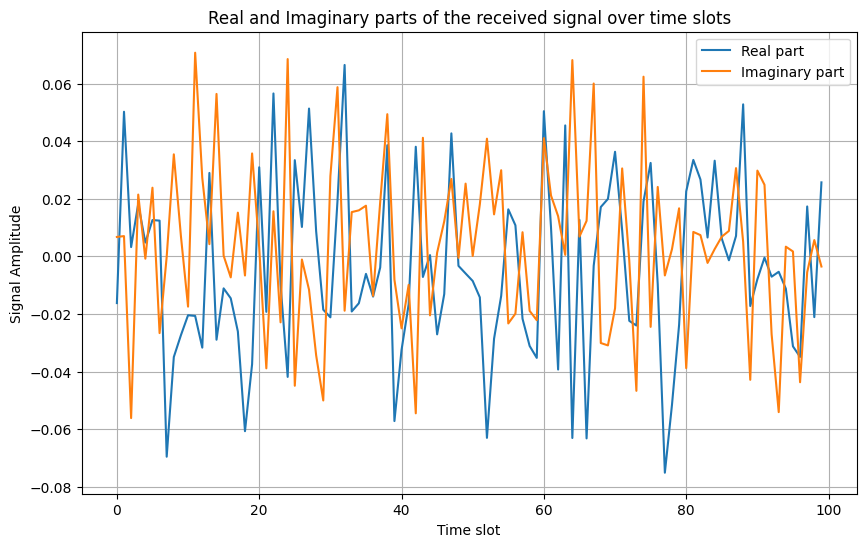

In [ ]:
# Constants and Parameters
M = 5  # Number of RISs
N = 10  # Number of elements per RIS
fc = 3e9  # Carrier frequency (3 GHz)
c = 3e8  # Speed of light (m/s)
lambda_c = c / fc  # Wavelength (m)
k = 2 * np.pi / lambda_c  # Wavenumber
sigma2 = 1e-3  # Noise variance (AWGN)
time_slots = 100  # Number of independent time slots

# Transmitter and RIS coordinates (assumed to be known)
tx_pos = np.array([0, 0])
ris_pos = np.random.uniform(low=-100, high=100, size=(M, 2))  # Random positions for RISs

# Initialize the unknown receiver position (we'll estimate this)
rx_true_pos = np.array([50, 50])  # True receiver position (unknown)

# Function to calculate distance between two points
def calc_distance(p1, p2):
    return np.linalg.norm(p1 - p2)

# Function to compute path loss using Friis transmission model
def calc_path_loss(d, epsilon=1):
    return epsilon / (4 * np.pi * d**2)

# Function to compute phase shifts across RIS elements
def calc_phase_shift(d, k, N, angle):
    phase_shifts = np.array([k * (d + n * lambda_c * np.sin(angle)) for n in range(N)])
    return np.exp(1j * phase_shifts)

# Channel model for a single RIS
def channel_model(tx_pos, rx_pos, ris_pos, N, k):
    d_tx_ris = calc_distance(tx_pos, ris_pos)
    d_ris_rx = calc_distance(ris_pos, rx_pos)

    # Compute path loss for both hops
    beta_tx = calc_path_loss(d_tx_ris)
    beta_rx = calc_path_loss(d_ris_rx)

    # Compute phase shifts for both hops
    angle_tx = np.arctan2(ris_pos[1] - tx_pos[1], ris_pos[0] - tx_pos[0])
    angle_rx = np.arctan2(rx_pos[1] - ris_pos[1], rx_pos[0] - ris_pos[0])

    h_tx = calc_phase_shift(d_tx_ris, k, N, angle_tx)
    h_rx = calc_phase_shift(d_ris_rx, k, N, angle_rx)

    # RIS diagonal phase shifting matrix
    Omega = np.diag(np.exp(1j * np.random.uniform(0, 2 * np.pi, N)))  # Random phase shifts at RIS

    # Composite channel
    h = beta_tx * beta_rx * h_rx.T @ Omega @ h_tx
    return h

# Received signal model
def received_signal(tx_pos, rx_pos, ris_pos, N, M, k, time_slots, sigma2):
    # Initialize received signal
    r_total = np.zeros(time_slots, dtype=complex)

    for t in range(time_slots):
        # Summing the contributions from all RISs
        h_sum = 0
        for m in range(M):
            h = channel_model(tx_pos, rx_pos, ris_pos[m], N, k)
            h_sum += h

        # Additive white Gaussian noise
        noise = np.random.normal(0, np.sqrt(sigma2), size=(1)) + 1j * np.random.normal(0, np.sqrt(sigma2), size=(1))

        # Received signal at time slot t
        r_total[t] = h_sum + noise

    return r_total

# Simulation: Estimate the received signals for the true receiver position
r_observed = received_signal(tx_pos, rx_true_pos, ris_pos, N, M, k, time_slots, sigma2)

# Plot the real and imaginary parts of the received signal
plt.figure(figsize=(10, 6))
plt.plot(np.real(r_observed), label="Real part")
plt.plot(np.imag(r_observed), label="Imaginary part")
plt.title("Real and Imaginary parts of the received signal over time slots")
plt.xlabel("Time slot")
plt.ylabel("Signal Amplitude")
plt.legend()
plt.grid(True)
plt.show()


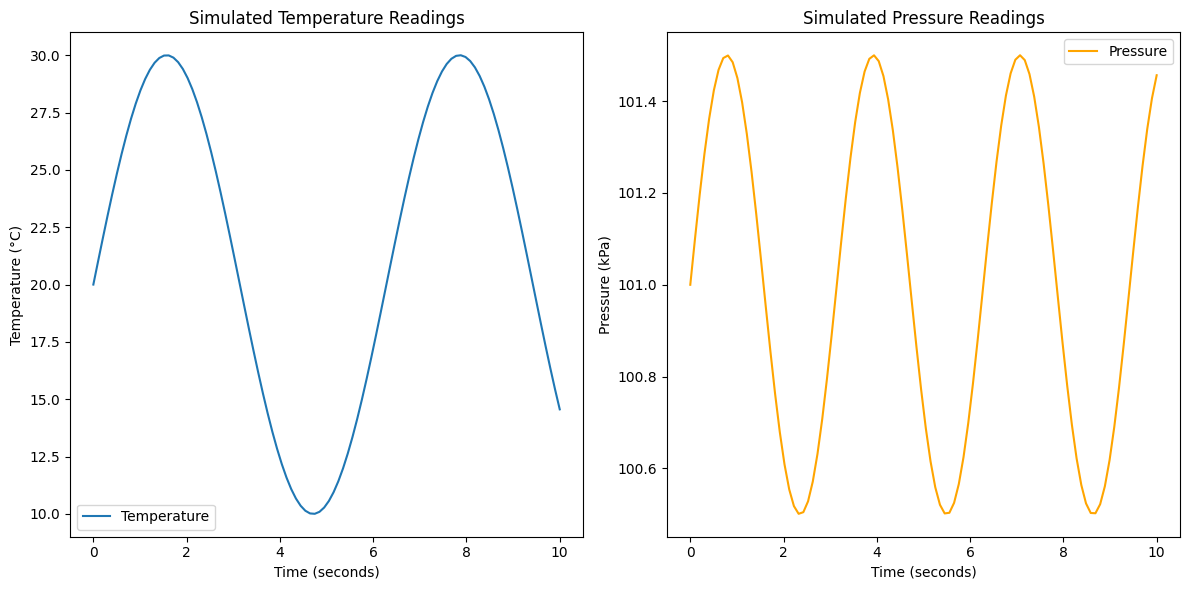

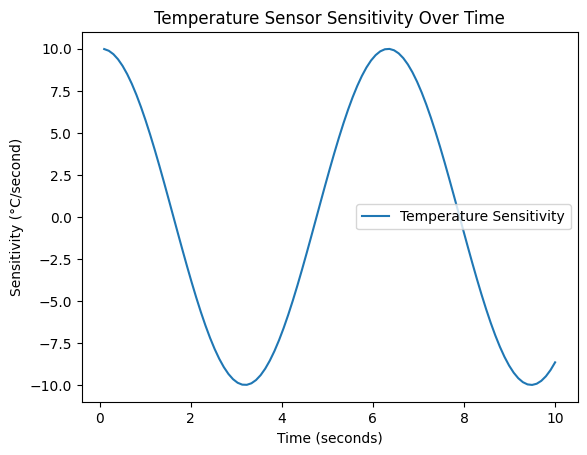

In [ ]:
# Function to simulate sensor data
def simulate_sensor_data(num_readings=100):
    time = np.linspace(0, 10, num_readings)  # Time array (0 to 10 seconds)
    temp_readings = 20 + 10 * np.sin(time)  # Simulated temperature readings
    pressure_readings = 101 + 0.5 * np.sin(2 * time)  # Simulated pressure readings
    return time, temp_readings, pressure_readings

# Function to calculate sensitivity (change in output/change in input)
def calculate_sensitivity(input_data, output_data):
    delta_output = np.diff(output_data)
    delta_input = np.diff(input_data)
    sensitivity = delta_output / delta_input
    return sensitivity

# Simulating sensor data
time, temp_readings, pressure_readings = simulate_sensor_data()

# Calculating sensitivity for temperature sensor
temp_sensitivity = calculate_sensitivity(time, temp_readings)

# Plotting the simulated data
plt.figure(figsize=(12, 6))

# Temperature readings plot
plt.subplot(1, 2, 1)
plt.plot(time, temp_readings, label="Temperature")
plt.xlabel("Time (seconds)")
plt.ylabel("Temperature (°C)")
plt.title("Simulated Temperature Readings")
plt.legend()

# Pressure readings plot
plt.subplot(1, 2, 2)
plt.plot(time, pressure_readings, label="Pressure", color='orange')
plt.xlabel("Time (seconds)")
plt.ylabel("Pressure (kPa)")
plt.title("Simulated Pressure Readings")
plt.legend()

plt.tight_layout()
plt.show()

# Displaying sensitivity calculation for temperature sensor
plt.plot(time[1:], temp_sensitivity, label="Temperature Sensitivity")
plt.xlabel("Time (seconds)")
plt.ylabel("Sensitivity (°C/second)")
plt.title("Temperature Sensor Sensitivity Over Time")
plt.legend()
plt.show()
